In [2]:
import pandas as pd


df_rna = pd.read_csv('g4_rna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()
df_dna = pd.read_csv('g4_dna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()

sum(df_rna.target == 1), sum(df_dna.target == 1)

(1101, 126)

In [3]:
for index, row in df_rna.iterrows():
    entry = row['Entry']
    target = row['target']
    seq = row['Sequence']
    with open('g4_rna_data.fasta', 'a') as f:
        f.write(f'>{entry} {target}\n{seq}\n')

for index, row in df_dna.iterrows():
    entry = row['Entry']
    target = row['target']
    seq = row['Sequence']
    with open('g4_dna_data.fasta', 'a') as f:
        f.write(f'>{entry} {target}\n{seq}\n')

This notebook demonstrates how to use [ESM-2](https://github.com/facebookresearch/esm) transformer protein language model to extract embeddings from provided protein sequences. The following code calculates the embeddings for each protein sequence in the training and test FASTA files and saves them as individual `.pt` files.

The resulting embedding can be loaded using the following code:
```
import torch

embedding = torch.load('[EntryID].pt')
embedding = embedding['mean_representations'][33].numpy()
```

Computing the embeddings and subsequently reading in the `.pt` files can take a while. The resulting numpy arrays can be found [here](https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-ems-2-embeddings-numpy).

**Note** that the test FASTA file contains duplicate entries. For this reason, this notebook uses cleaned FASTA files, which can be found [here](https://www.kaggle.com/datasets/viktorfairuschin/cafa-5-fasta-files).

In [4]:
%pip install -q fair-esm


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import pathlib
import torch

from esm import FastaBatchedDataset, pretrained

In [6]:
def extract_embeddings(model_name, fasta_file, output_dir, tokens_per_batch=4096, seq_length=1022,repr_layers=[33]):

    model, alphabet = pretrained.load_model_and_alphabet(model_name)
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()

    dataset = FastaBatchedDataset.from_file(fasta_file)
    batches = dataset.get_batch_indices(tokens_per_batch, extra_toks_per_seq=1)

    data_loader = torch.utils.data.DataLoader(
        dataset,
        collate_fn=alphabet.get_batch_converter(seq_length),
        batch_sampler=batches
    )

    output_dir.mkdir(parents=True, exist_ok=True)

    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_loader):

            print(f'Processing batch {batch_idx + 1} of {len(batches)}')

            if torch.cuda.is_available():
                toks = toks.to(device="cuda", non_blocking=True)

            out = model(toks, repr_layers=repr_layers, return_contacts=False)

            logits = out["logits"].to(device="cpu")
            representations = {layer: t.to(device="cpu") for layer, t in out["representations"].items()}

            for i, label in enumerate(labels):
                entry_id = label.split()[0]

                filename = output_dir / f"{entry_id}.pt"
                truncate_len = min(seq_length, len(strs[i]))

                result = {"entry_id": entry_id}
                result["mean_representations"] = {
                        layer: t[i, 1 : truncate_len + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }

                torch.save(result, filename)

In [21]:
import pandas as pd


df_rna = pd.read_csv('g4_rna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()
df_dna = pd.read_csv('g4_dna_data.csv').drop(columns=['Unnamed: 0']).drop_duplicates()

df_dna.target = (df_dna.target == 1) * 2

df = pd.concat([df_rna, df_dna]).drop_duplicates()
df = df.groupby(by=['Entry', 'Sequence'], as_index=False).max().drop_duplicates()
df

,Entry,Sequence,target
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0
...,...,...,...
14250,Q9Y6Y0,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...,0
14251,Q9Y6Y1,MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNS...,0
14252,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...,0
14253,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,0


In [22]:
for index, row in df.iterrows():
    entry = row['Entry']
    target = row['target']
    seq = row['Sequence']
    with open('g4_data.fasta', 'a') as f:
        f.write(f'>{entry}_{target}_{seq[:10]}\n{seq}\n')


In [23]:
model_name = 'esm2_t33_650M_UR50D'
fasta_file = pathlib.Path('g4_data.fasta')
output_dir = pathlib.Path('g4_embeddings')

extract_embeddings(model_name, fasta_file, output_dir)

Processing batch 1 of 2449
Processing batch 2 of 2449
Processing batch 3 of 2449
Processing batch 4 of 2449
Processing batch 5 of 2449
Processing batch 6 of 2449
Processing batch 7 of 2449
Processing batch 8 of 2449
Processing batch 9 of 2449
Processing batch 10 of 2449
Processing batch 11 of 2449
Processing batch 12 of 2449
Processing batch 13 of 2449
Processing batch 14 of 2449
Processing batch 15 of 2449
Processing batch 16 of 2449
Processing batch 17 of 2449
Processing batch 18 of 2449
Processing batch 19 of 2449
Processing batch 20 of 2449
Processing batch 21 of 2449
Processing batch 22 of 2449
Processing batch 23 of 2449
Processing batch 24 of 2449
Processing batch 25 of 2449
Processing batch 26 of 2449
Processing batch 27 of 2449
Processing batch 28 of 2449
Processing batch 29 of 2449
Processing batch 30 of 2449
Processing batch 31 of 2449
Processing batch 32 of 2449
Processing batch 33 of 2449
Processing batch 34 of 2449
Processing batch 35 of 2449
Processing batch 36 of 2449
P

In [5]:
import torch

result = []

for index, row in df.iterrows():
    entry = row['Entry']
    seq = row['Sequence']
    target = row['target']
    embedding = torch.load(f'./g4_embeddings/{entry}_{target}_{seq[:10]}.pt')
    embedding = embedding['mean_representations'][33].numpy()
    result.append(embedding)


df['embeddings'] = result
df

,Entry,Sequence,target,embeddings
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2,"[-0.014424162, -0.12747854, -0.025471963, 0.13..."
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2,"[-0.014431701, -0.07910665, -0.038373616, -0.0..."
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0,"[0.13709556, 0.0055530276, -0.04580763, -0.013..."
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0,"[0.12307612, 0.049242545, 0.090544134, 0.03007..."
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0,"[-0.013960375, -0.0034377251, -0.1280868, 0.15..."
...,...,...,...,...
14250,Q9Y6Y0,MIPNGYLMFEDENFIESSVAKLNALRKSGQFCDVRLQVCGHEMLAH...,0,"[-0.013813948, -0.04196723, 0.057689615, 0.026..."
14251,Q9Y6Y1,MWRAEGKWLPKTSRKSVSQSVFCGTSTYCVLNTVPPIEDDHGNSNS...,0,"[0.03529887, -0.11825983, 0.011657646, 0.10678..."
14252,Q9Y6Y8,MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...,0,"[0.04143346, -0.088862054, 0.004902995, 0.0679..."
14253,Q9Y6Y9,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,0,"[0.0016057957, -0.006012006, -0.010348496, 0.0..."


In [7]:
df_embed = pd.DataFrame(list(df['embeddings']))
df = pd.concat([df.drop(columns=['embeddings']), df_embed], axis=1)
df

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2,-0.014424,-0.127479,-0.025472,0.131329,-0.081169,-0.069362,0.055973,0.024433,-0.076489,0.111706,0.014603,-0.061753,0.077135,0.087542,0.076338,0.056041,0.021354,0.097799,-0.004003,0.081966,0.123599,0.043342,0.109978,-0.115901,0.034905,0.064684,-0.004946,-0.064966,-0.022880,-0.107975,0.008689,-0.015882,0.111728,0.083106,0.036483,0.107028,-0.053431,...,-0.113314,0.008570,-0.079901,0.072769,0.121122,0.040692,0.086764,0.009611,-0.055255,-0.037851,0.049378,0.115581,0.058393,-0.060533,0.062005,-0.044844,-0.004486,-0.140451,-0.000608,0.055741,0.074734,-0.047509,0.091350,0.149022,0.059649,-0.079865,0.049508,0.029068,-0.054367,-0.006949,-0.016602,-0.076636,-0.086266,-0.011988,0.010882,-0.117605,-0.000137,-0.172737,0.080778,0.062243
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2,-0.014432,-0.079107,-0.038374,-0.013817,-0.042201,-0.055915,0.041759,0.025957,-0.057664,0.085040,0.031012,-0.033947,0.074409,0.073915,0.026920,0.074018,0.017362,0.078643,-0.040525,0.067356,0.097761,-0.042598,0.082389,-0.066336,0.081110,0.104106,0.001706,0.007012,-0.044590,-0.111734,-0.001651,-0.021177,0.039646,-0.005535,-0.016896,0.037831,-0.024963,...,-0.160654,0.051260,-0.038241,0.035094,0.083455,-0.079555,0.067447,-0.028005,-0.029179,-0.028264,0.042686,0.114785,0.062199,-0.000834,0.060207,0.003395,-0.104053,-0.027597,0.058989,0.057497,-0.004782,0.039768,-0.020190,0.090324,0.022601,-0.029332,-0.003039,0.060467,-0.047548,0.026835,-0.035397,0.003773,-0.086862,0.008779,-0.018460,-0.036112,0.033607,-0.108594,-0.009330,0.088036
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0,0.137096,0.005553,-0.045808,-0.013459,0.072212,-0.120980,0.069426,-0.017689,-0.002734,0.116205,0.042270,-0.080327,0.008148,0.106807,-0.011670,0.123439,-0.005831,-0.013107,-0.037219,-0.028884,-0.071797,-0.029889,-0.114616,-0.132105,0.003956,0.052264,0.028496,-0.097310,0.018623,-0.126699,-0.019111,0.105966,0.118878,0.012017,0.007132,0.089328,-0.095407,...,-0.076255,0.019581,-0.036441,0.141297,0.091229,0.023655,0.139093,0.104719,-0.113022,0.049914,0.094263,0.000021,-0.019008,0.074556,0.020612,-0.033228,-0.072225,0.094724,0.027877,0.163563,0.053133,0.042850,0.065975,0.057532,0.087883,-0.018227,-0.011600,-0.021231,0.019615,-0.035513,0.104858,-0.140908,-0.021359,-0.008463,0.027179,-0.005935,0.169098,-0.074238,-0.052271,0.082880
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0,0.123076,0.049243,0.090544,0.030078,-0.088725,-0.078453,-0.116866,0.295149,0.112689,0.045739,0.104099,0.035527,-0.019359,0.017223,-0.086056,-0.018034,0.000113,0.057047,0.040393,-0.107112,0.187712,-0.044826,0.001382,0.106162,0.099995,-0.031755,-0.027995,-0.118600,-0.012352,-0.116555,-0.059366,0.003082,0.087235,0.006243,0.090666,0.129838,-0.078193,...,0.048798,0.141007,-0.123084,-0.163467,0.085526,-0.001118,-0.087812,-0.047877,0.117660,-0.027678,-0.050695,0.030051,0.056828,-0.017331,-0.062991,-0.010218,-0.213436,0.033951,0.010504,0.094222,-0.059084,0.083669,0.093811,-0.044334,-0.112464,-0.075080,0.031032,0.027135,0.049170,0.005680,-0.039030,-0.027126,-0.097276,0.094532,0.026466,0.128167,0.035770,0.120640,-0.079143,0.047750
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0,-0.013960,-0.003438,-0.128087,0.156853,-0.155170,-0.058466,0.090934,0.119163,-0.023382,0.171526,0.066230,0.111581,0.126546,0.020185,0.061344,-0.005643,0.053320,0.010156,-0.058002,0.252097,0.169814,-0.022317,0.035335,-0.104520,0.001403,0.202209,-0.066111,-0.091769,-0.123189,-0.180374,-0.122107,0.211045,-0.045128,0.032426,0.168544,0.132967,-0.176035,...,-0.085885,-0.095818,-0.124637,-0.041423,0.126941,0.080085,0.101991,0.058154,0.122991,-0.027155,-

In [8]:
df.to_csv('all_g4_data_esm.csv')

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV


In [76]:
df = pd.read_csv('all_g4_data_esm.csv').drop(columns=['Unnamed: 0'])

In [77]:
df_rna_raw = df[df.target.isin([0, 1])]
df_dna_raw = df[df.target.isin([0, 2])]

In [4]:
sum(df_dna_raw.target == 2)

126

In [78]:
df_rna = df_rna_raw.groupby('target').apply(lambda x: x.sample(n=1100)).reset_index(drop = True)
df_dna = df_dna_raw.groupby('target').apply(lambda x: x.sample(n=126)).reset_index(drop = True)

In [9]:
df_dna

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,P51159,MSDGDYDYLIKFLALGDSGVGKTSVLYQYTDGKFNSKFITTVGIDF...,0,-0.006412,0.023080,0.021503,-0.000421,-0.040962,-0.148571,0.080904,-0.084527,-0.055225,0.098920,0.043193,-0.026033,0.028093,0.101194,0.023907,0.058865,-0.032142,-0.036699,0.049544,0.016328,-0.045001,-0.012753,0.079694,0.015314,0.091457,0.081729,0.016937,-0.034871,0.056225,-0.155840,0.004454,0.043369,-0.025060,-0.030072,0.018356,0.076686,-0.026646,...,-0.110443,0.036505,-0.085395,0.073892,0.036219,-0.003311,-0.013614,0.106864,-0.013557,-0.033801,0.025340,0.006777,-0.032554,0.067999,0.109889,0.026505,-0.053429,0.008835,0.137253,-0.001919,0.057133,0.113087,0.128208,0.128647,0.003370,-0.013039,-0.066069,-0.026321,0.051918,-0.013042,0.038008,-0.073855,-0.052341,0.020593,-0.049833,-0.032854,0.018775,-0.160508,0.036274,0.044398
1,Q9HCK8,MADPIMDLFDDPNLFGLDSLTDDSFNQVTQDPIEEALGLPSSLDSL...,0,0.034821,-0.084096,0.001776,0.028488,0.080327,-0.087918,0.044883,0.041387,0.017355,0.090665,0.027703,-0.011834,0.033467,0.053825,-0.014360,0.099070,0.011954,0.086009,0.012224,0.012336,0.035281,0.002418,0.022703,0.027809,0.061290,0.031653,0.011138,-0.040819,-0.000927,-0.147645,-0.022291,0.071160,0.000565,-0.016511,0.040636,0.073056,-0.040646,...,-0.172652,-0.018693,-0.070638,0.027426,0.053780,-0.008790,0.018719,0.105471,-0.049226,0.023574,0.064678,0.012306,-0.008754,-0.013922,0.066806,0.014373,-0.081703,-0.017073,0.063820,0.023017,-0.012316,0.041584,0.096418,-0.026932,0.010367,0.001315,0.000724,-0.060657,0.015638,-0.048506,0.029344,0.024664,-0.110817,-0.037543,0.038617,-0.109048,0.055292,-0.066240,0.073956,0.075447
2,P17677,MLCCMRRTKQVEKNDDDQKIEQDGIKPEDKAHKAATKIQASFRGHI...,0,0.105398,-0.189935,-0.230500,0.179431,0.197918,-0.041178,0.092068,-0.087245,0.010545,0.153643,0.000726,-0.020710,0.052295,-0.044805,-0.060273,0.032854,0.107072,0.130366,0.042187,0.195924,0.089524,0.112928,0.033319,0.064111,-0.044522,-0.074971,0.063642,-0.032630,-0.057174,-0.028611,0.020024,0.109347,0.161315,0.043864,-0.088470,0.129396,-0.103468,...,-0.189362,0.130150,-0.219326,0.165268,0.037047,0.109029,0.032064,-0.066083,-0.113912,-0.250555,0.069546,0.020344,-0.011967,0.138539,0.157307,-0.061774,0.077761,-0.094996,0.061057,-0.081811,0.028827,0.060077,0.014676,-0.019729,0.210611,-0.032304,-0.091540,-0.076444,0.000151,-0.028611,0.080201,0.009988,-0.098881,0.054847,0.046046,-0.196001,-0.014306,-0.191685,-0.041869,0.152835
3,Q9BXP2,MASESSPLLAYRLLGEEGVALPANGAGGPGGASARKLSTFLGVVVP...,0,-0.036511,-0.090523,0.047036,0.011367,-0.022946,0.018862,0.132923,-0.038245,0.005777,0.171035,0.014444,-0.067354,0.058212,0.202033,0.046714,0.153865,0.064166,0.110141,-0.122218,0.098199,0.100355,0.018995,0.048791,-0.174421,0.047187,0.087538,-0.051082,-0.022114,0.082306,-0.071205,-0.046885,0.034281,0.078883,0.028843,0.039558,0.017243,-0.042538,...,-0.059739,-0.000223,-0.149498,0.057959,0.082161,-0.030998,0.078753,-0.043036,-0.077202,0.049372,0.040086,0.192648,0.079439,0.004077,0.053342,-0.048980,-0.194259,-0.187699,0.106580,0.110806,0.063429,-0.114155,0.067140,0.216995,0.164665,-0.158296,-0.025724,0.004672,-0.121197,0.071444,-0.098991,0.015023,-0.219456,0.086216,-0.014967,-0.102981,-0.065716,-0.101334,0.060869,0.139330
4,Q15532,MSVAFAAPRQRGKGEITPAAIQKMLDDNNHLIQCIMDSQNKGKTSE...,0,-0.048369,-0.132040,0.032389,0.065664,-0.023937,-0.143714,0.133715,0.068485,-0.057033,0.112834,-0.082291,0.104331,0.030897,0.040952,-0.047699,0.159965,-0.063408,-0.084737,-0.040823,-0.135082,-0.064858,0.060113,-0.026654,0.080311,-0.043662,-0.011007,-0.015561,0.016617,0.163540,-0.075003,-0.077895,-0.116732,-0.046214,0.099309,-0.012411,0.266855,-0.060833,...,-0.088940,-0.025391,-0.012058,0.031467,0.097530,-0.076127,0.012560,0.061262,-0.082547,-0.222785

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_rna, test_size=0.3)
train

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
1538,Q5JTH9,MGRSGKLPSGVSAKLKRWKKGHSSDSNPAICRHRQAARSRFFSRPS...,1,-0.014404,0.003317,0.057573,0.079362,-0.067707,0.014574,0.190080,-0.113595,0.016758,0.188235,0.025546,-0.059337,0.116022,0.088756,0.035891,0.141763,0.064448,0.166232,-0.071647,0.122873,0.121323,-0.026150,0.119416,-0.161081,0.055124,0.067677,0.015990,-0.107398,-0.060274,-0.096702,-0.026459,0.063628,0.021740,0.036418,0.158821,0.134039,-0.146151,...,-0.070364,-0.069722,-0.170936,0.080063,0.075591,-0.029797,0.149473,0.034298,0.008857,-0.079814,0.020018,0.097189,0.132685,0.081660,0.163090,0.003798,-0.058231,-0.128084,0.047500,0.057247,0.109120,0.051118,-0.010267,0.155395,0.095191,-0.030043,0.006836,0.066139,-0.073541,-0.078291,-0.029365,0.016837,-0.174566,0.015747,-0.070591,-0.018935,0.025162,-0.081690,0.038080,0.131798
443,P61106,MATAPYNYSYIFKYIIIGDMGVGKSCLLHQFTEKKFMADCPHTIGV...,0,-0.018058,0.023285,-0.038285,0.008383,-0.066606,-0.128559,0.129540,-0.107691,-0.037149,0.098194,0.067392,-0.023131,0.021917,0.095539,0.073468,0.049289,-0.034231,-0.041058,0.041334,0.037968,-0.022696,0.023291,0.075051,0.027377,0.076910,0.085243,0.024578,-0.056129,0.062867,-0.143778,-0.012785,0.088838,0.022890,-0.018605,0.041768,0.125215,-0.072684,...,-0.111384,0.041716,-0.112581,0.095480,0.082045,0.016693,-0.027774,0.072708,-0.007165,-0.029312,0.072181,0.001875,-0.037103,0.127029,0.125174,0.018583,-0.068832,-0.070379,0.185300,0.019395,0.044933,0.126306,0.153038,0.091147,0.027214,-0.025613,-0.082850,-0.044616,0.072542,-0.023431,0.032175,-0.065816,-0.074415,0.024702,-0.066822,-0.030703,0.012173,-0.156497,0.012039,0.037333
2004,Q14493,MACRPRSPPRHQSRCDGDASPPSPARWSLGRKRRADGRRWRPEDAE...,1,0.011628,-0.010004,0.032334,-0.003311,0.042197,-0.053605,0.000533,0.143762,0.013472,0.021057,0.031347,-0.002066,0.086409,0.019508,0.020522,0.120500,-0.020513,-0.007829,-0.013513,-0.031714,0.000008,0.024698,0.046206,0.112707,0.080466,0.051903,0.035680,-0.061955,0.027362,-0.113828,-0.042709,-0.015656,0.077899,0.011381,0.023986,0.044818,-0.031435,...,-0.029441,0.064441,-0.024525,-0.056301,-0.000558,0.004175,-0.041500,0.016438,-0.018315,0.116397,-0.024137,-0.029501,-0.004525,-0.025311,-0.053338,0.019187,-0.109736,0.001249,-0.070883,0.007280,-0.002698,0.012136,0.106011,0.145032,-0.040224,-0.063579,0.089610,0.014759,0.028372,0.097481,0.078124,0.008307,-0.068959,0.056614,0.030790,0.034741,-0.006588,-0.027536,-0.005871,-0.022836
1129,Q9UI10,MAAVAVAVREDSGSGMKAELPPGPGAVGREMTKEEKLQLRKEKKQQ...,1,0.047247,-0.113121,-0.003438,0.041770,-0.127493,-0.057523,0.089506,0.002487,0.017554,0.127726,0.004384,0.009610,0.070950,0.014794,0.022126,0.149802,0.016855,0.033063,0.004896,0.156469,0.087823,0.028085,0.106433,-0.123405,-0.053473,0.116427,-0.088888,-0.023317,0.001846,-0.131906,-0.068196,0.072562,0.073160,0.025492,0.007689,0.095060,-0.052642,...,-0.111051,0.042563,-0.130276,0.068959,0.048756,-0.011796,0.005203,-0.021797,-0.075893,0.010794,0.082438,0.025951,0.067882,0.038081,0.084501,-0.097256,-0.052213,-0.041595,0.031216,0.005721,0.061479,0.015712,0.026077,0.105305,0.139838,-0.068917,-0.062430,-0.060579,-0.056204,0.008470,-0.041165,0.017749,-0.218899,0.028703,0.045058,-0.141961,0.058197,-0.092745,0.082981,0.071308
582,Q9NRX6,MTNVYSLDGILVFGLLFVCTCAYFKKVPRLKTWLLSEKKGVWGVFY...,0,0.028750,-0.023104,-0.016004,-0.028327,-0.120319,0.109240,0.029340,0.102946,0.019407,-0.102762,0.001378,0.011819,0.185279,0.062736,-0.050212,0.030539,0.012548,0.012227,-0.074780,-0.070560,0.032896,-0.073052,0.017377,0.066632,-0.032364,0.039996,-0.003653,0.064178,0.009665,-0.181465,0.024316,0.009933,0.137178,-0.095281,0.022544,0.035215,0.079191,...,-0.007538,0.049316,0.064792,0.011925,0.030549,0.024530,0.027156,0.226000,-0.005746,0.152850,0.1

In [79]:
y_train = train['target']
X_train = train.iloc[:, 3:]
y_test = test['target']
X_test = test.iloc[:, 3:]

In [9]:

parameters = {
    'activation' : ['relu', 'tanh', 'logistic'],
    'solver': ['lbfgs', 'adam'],
    'hidden_layer_sizes' : [ [2 ** s] * i for s in range(5, 8) for i in range (3, 6)],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
              
}
model = MLPClassifier(
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.2,
    random_state=42,
    n_iter_no_change=100,
    batch_size=int(1e9),
)

clf = GridSearchCV(
    model, 
    parameters, 
    verbose=3, 
    cv=2, 
    scoring='roc_auc',
    n_jobs=7,
)
clf.fit(X_train,y_train)
best_model = clf.best_estimator_
print("  Activation Function: %s" % clf.best_estimator_.activation)
print("   Hidden Layer Sizes: %s" % clf.best_estimator_.hidden_layer_sizes)
print("                Alpha: %f" % clf.best_estimator_.alpha)
y_pred = best_model.predict(X_test)
print("             Accuracy: %f" % accuracy_score(y_test, y_pred))


Fitting 2 folds for each of 162 candidates, totalling 324 fits
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32], learning_rate=invscaling, solver=lbfgs;, score=0.781 total time=   5.0s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32], learning_rate=adaptive, solver=adam;, score=0.824 total time=   1.4s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32], learning_rate=constant, solver=lbfgs;, score=0.796 total time=   5.1s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32], learning_rate=adaptive, solver=lbfgs;, score=0.796 total time=   5.1s
[CV 1/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32], learning_rate=constant, solver=adam;, score=0.827 total time=   1.4s
[CV 1/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32], learning_rate=invscaling, solver=lbfgs;, score=0.754 total time=   7.9s
[CV 2/2] END activation=relu, hidden_layer_sizes=[32, 32, 32, 32, 32], learning_rate=adaptive, solver=adam;, scor

In [103]:

parameters = {
    'activation' : 'tanh',
    'solver': 'adam',
    'hidden_layer_sizes' : [64, 64, 64, 64],
    'learning_rate': ['constant'],
              
}
model = MLPClassifier(
    max_iter=20,
    early_stopping=True,
    validation_fraction=0.3,
    random_state=42,
    n_iter_no_change=115,
    # batch_size=int(1e9),
)

model.fit(X_train,y_train)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test)
print("             Accuracy: %f" % accuracy_score(y_test, y_pred))


  Activation Function: relu
   Hidden Layer Sizes: 100
                Alpha: 0.000100
             Accuracy: 0.766667


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


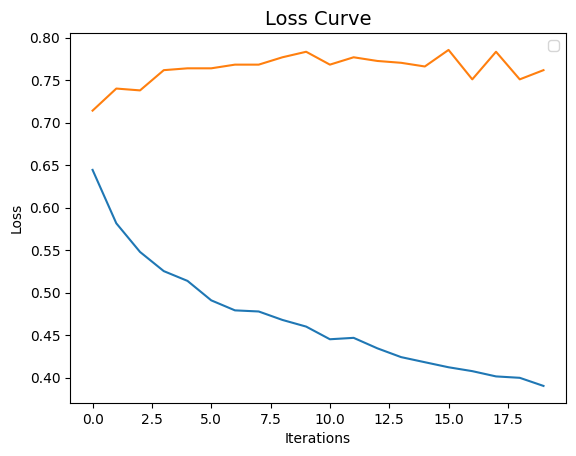

In [104]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [105]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('Accuracy Test: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy Train: {:.2f}'.format(accuracy_score(y_train, y_pred_train)))


Accuracy Test: 0.77
Accuracy Train: 0.81


In [106]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.8294916904759717

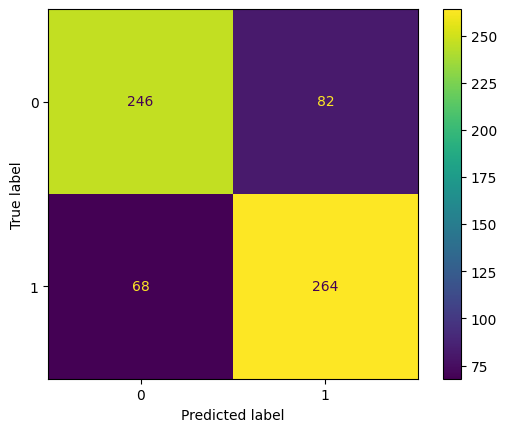

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


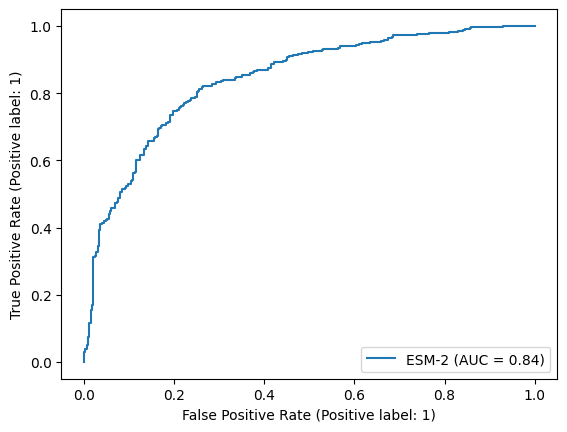

In [206]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    model, X_test, y_test, name="ESM-2", pos_label=1
)


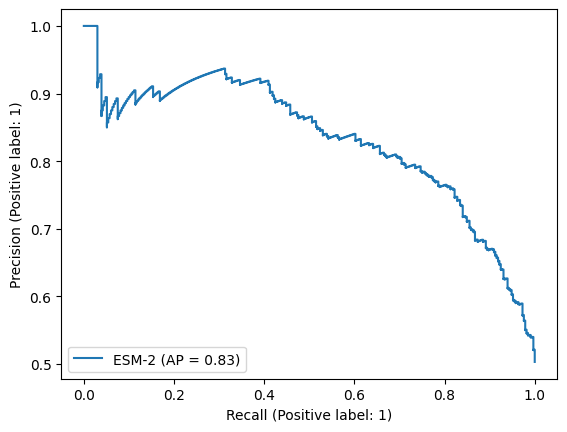

In [207]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="ESM-2"
)


In [10]:
train_dna, test_dna = train_test_split(df_dna, test_size=0.5)
y_train_dna = train_dna['target']
X_train_dna = train_dna.iloc[:, 3:]
y_test_dna = test_dna['target']
X_test_dna = test_dna.iloc[:, 3:]

In [11]:

parameters = {
    'activation' : 'tanh',
    'solver': 'adam',
    'hidden_layer_sizes' : [64, 64, 64, 64],
    'learning_rate': ['constant'],
              
}
model = MLPClassifier(
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.5,
    random_state=42,
    n_iter_no_change=25,
    # batch_size=10,
)

model.fit(X_train_dna,y_train_dna)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test_dna)
print("             Accuracy: %f" % accuracy_score(y_test_dna, y_pred))


  Activation Function: relu
   Hidden Layer Sizes: 100
                Alpha: 0.000100
             Accuracy: 0.706349


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


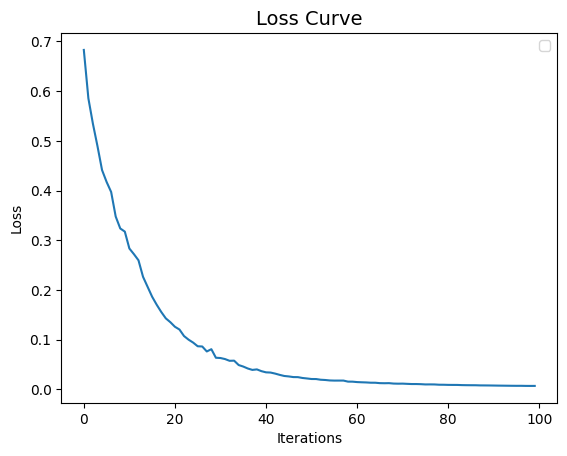

In [12]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
# plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
y_pred = model.predict(X_test_dna)
y_pred_train = model.predict(X_train_dna)

print('Accuracy Test: {:.2f}'.format(accuracy_score(y_test_dna, y_pred)))
print('Accuracy Train: {:.2f}'.format(accuracy_score(y_train_dna, y_pred_train)))


Accuracy Test: 0.71
Accuracy Train: 1.00


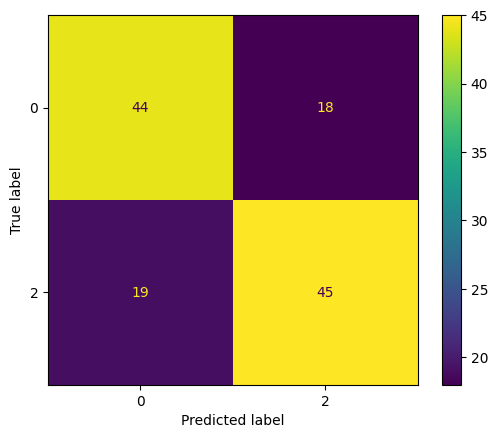

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_dna, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()


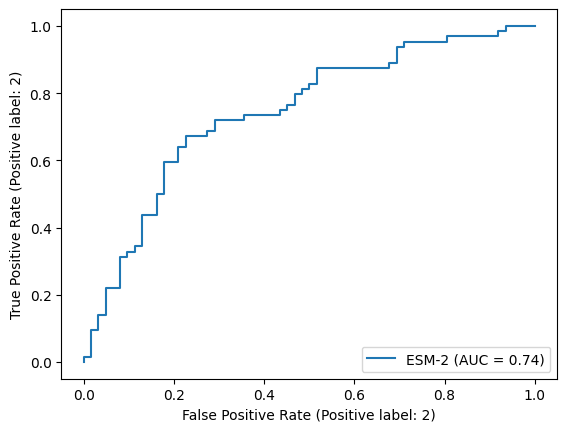

In [15]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    model, X_test_dna, y_test_dna, name="ESM-2", pos_label=2
)


In [16]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test_dna, model.predict_proba(X_test_dna)[:, 1])

0.7442036290322581

In [12]:
df

,Entry,Sequence,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,A0A0A7DIX5,MAAASGYTDLREKLKSMTSRDNYKAGSREAAAAAAAAVAAAAAAAA...,2,-0.014424,-0.127479,-0.025472,0.131329,-0.081169,-0.069362,0.055973,0.024433,-0.076489,0.111706,0.014603,-0.061753,0.077135,0.087542,0.076338,0.056041,0.021354,0.097799,-0.004003,0.081966,0.123599,0.043342,0.109978,-0.115901,0.034905,0.064684,-0.004946,-0.064966,-0.022880,-0.107975,0.008689,-0.015882,0.111728,0.083106,0.036483,0.107028,-0.053431,...,-0.113314,0.008570,-0.079901,0.072769,0.121122,0.040692,0.086764,0.009611,-0.055255,-0.037851,0.049378,0.115581,0.058393,-0.060533,0.062005,-0.044844,-0.004486,-0.140451,-0.000608,0.055741,0.074734,-0.047509,0.091350,0.149022,0.059649,-0.079865,0.049508,0.029068,-0.054367,-0.006949,-0.016602,-0.076636,-0.086266,-0.011988,0.010882,-0.117605,-0.000137,-0.172737,0.080778,0.062243
1,A0A0A7DIX5,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,2,-0.014432,-0.079107,-0.038374,-0.013817,-0.042201,-0.055915,0.041759,0.025957,-0.057664,0.085040,0.031012,-0.033947,0.074409,0.073915,0.026920,0.074018,0.017362,0.078643,-0.040525,0.067356,0.097761,-0.042598,0.082389,-0.066336,0.081110,0.104106,0.001706,0.007012,-0.044590,-0.111734,-0.001651,-0.021177,0.039646,-0.005535,-0.016896,0.037831,-0.024963,...,-0.160654,0.051260,-0.038241,0.035094,0.083455,-0.079555,0.067447,-0.028005,-0.029179,-0.028264,0.042686,0.114785,0.062199,-0.000834,0.060207,0.003395,-0.104053,-0.027597,0.058989,0.057497,-0.004782,0.039768,-0.020190,0.090324,0.022601,-0.029332,-0.003039,0.060467,-0.047548,0.026835,-0.035397,0.003773,-0.086862,0.008779,-0.018460,-0.036112,0.033607,-0.108594,-0.009330,0.088036
2,A0A0B4J2F0,MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...,0,0.137096,0.005553,-0.045808,-0.013459,0.072212,-0.120980,0.069426,-0.017689,-0.002734,0.116205,0.042270,-0.080327,0.008148,0.106807,-0.011670,0.123439,-0.005831,-0.013107,-0.037219,-0.028884,-0.071797,-0.029889,-0.114616,-0.132105,0.003956,0.052264,0.028496,-0.097310,0.018623,-0.126699,-0.019111,0.105966,0.118878,0.012017,0.007132,0.089328,-0.095407,...,-0.076255,0.019581,-0.036441,0.141297,0.091229,0.023655,0.139093,0.104719,-0.113022,0.049914,0.094263,0.000021,-0.019008,0.074555,0.020612,-0.033228,-0.072225,0.094724,0.027877,0.163563,0.053133,0.042850,0.065975,0.057532,0.087883,-0.018227,-0.011600,-0.021231,0.019615,-0.035513,0.104858,-0.140908,-0.021359,-0.008463,0.027179,-0.005935,0.169098,-0.074238,-0.052271,0.082880
3,A0A0C5B5G6,MRWQEMGYIFYPRKLR,0,0.123076,0.049243,0.090544,0.030078,-0.088725,-0.078453,-0.116866,0.295149,0.112689,0.045739,0.104099,0.035527,-0.019359,0.017223,-0.086056,-0.018034,0.000113,0.057047,0.040393,-0.107112,0.187712,-0.044826,0.001382,0.106162,0.099995,-0.031755,-0.027995,-0.118600,-0.012352,-0.116555,-0.059366,0.003082,0.087235,0.006243,0.090666,0.129838,-0.078193,...,0.048798,0.141007,-0.123084,-0.163467,0.085526,-0.001118,-0.087812,-0.047877,0.117660,-0.027678,-0.050695,0.030051,0.056828,-0.017331,-0.062991,-0.010218,-0.213437,0.033951,0.010504,0.094222,-0.059084,0.083669,0.093811,-0.044334,-0.112464,-0.075080,0.031032,0.027135,0.049170,0.005680,-0.039030,-0.027126,-0.097276,0.094532,0.026466,0.128167,0.035770,0.120640,-0.079143,0.047750
4,A0A0K2S4Q6,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,0,-0.013960,-0.003438,-0.128087,0.156853,-0.155170,-0.058466,0.090934,0.119163,-0.023382,0.171526,0.066230,0.111581,0.126546,0.020185,0.061344,-0.005643,0.053320,0.010156,-0.058002,0.252097,0.169814,-0.022317,0.035335,-0.104520,0.001403,0.202209,-0.066111,-0.091769,-0.123189,-0.180374,-0.122107,0.211045,-0.045128,0.032426,0.168544,0.132967,-0.176035,...,-0.085885,-0.095818,-0.124637,-0.041423,0.126941,0.080085,0.101991,0.058154,0.122991,-0.027155,-

In [57]:
sum(df.target == 1)


1227

In [166]:
df_all = df
df_all.target = df_all.target.apply(lambda x: int(bool(x)))
df_all = df_all.groupby('target').apply(lambda x: x.sample(n=1226)).reset_index(drop = True)
train_all, test_all = train_test_split(df_all, test_size=0.3)
y_train_all = train_all['target']
X_train_all = train_all.iloc[:, 3:]
y_test_all = test_all['target']
X_test_all = test_all.iloc[:, 3:]

In [40]:
y_train_all

436     0
1227    1
2009    1
2050    1
1868    1
       ..
2326    1
247     0
1965    1
526     0
2377    1
Name: target, Length: 1716, dtype: int64

In [63]:

parameters = {
    'activation' : 'tanh',
    'solver': 'adam',
    'hidden_layer_sizes' : [64, 64, 64, 64],
    'learning_rate': 'constant',
              
}
model = MLPClassifier(
    max_iter=3000,
    early_stopping=True,
    validation_fraction=0.3,
    random_state=42,
    n_iter_no_change=1000,
    batch_size=10000,
    **parameters,
)

model.fit(X_train_all, y_train_all)
print("  Activation Function: %s" % model.activation)
print("   Hidden Layer Sizes: %s" % model.hidden_layer_sizes)
print("                Alpha: %f" % model.alpha)
y_pred = model.predict(X_test_all)
print("             Accuracy: %f" % accuracy_score(y_test_all, y_pred))


  Activation Function: tanh
   Hidden Layer Sizes: [64, 64, 64, 64]
                Alpha: 0.000100
             Accuracy: 0.740489


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


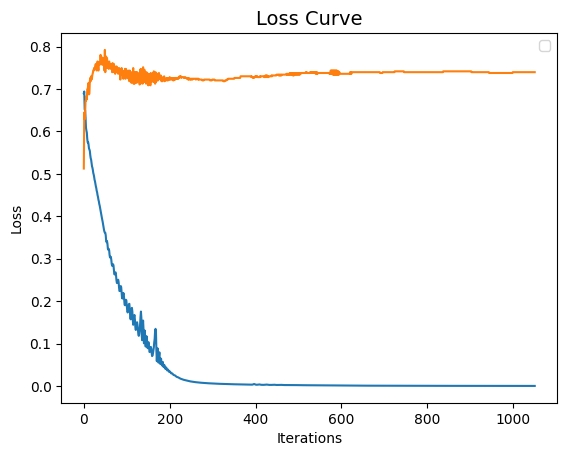

In [64]:
plt.plot(model.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.plot(model.validation_scores_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [65]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_test_all, model.predict_proba(X_test_all)[:, 1])

0.8276084251688589

In [66]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [136]:
xgb = XGBClassifier(objective= 'binary:logistic')
# y_train_dna = y_train_dna.apply(lambda x: int(bool(x)))
xgb.fit(X_train_all, y_train_all)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [137]:
preds_train = xgb.predict(X_train_all)
preds_test = xgb.predict(X_test_all)
print('XGBoosting:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train_all, y_pred=preds_train),
    accuracy_score(y_true=y_test_all, y_pred=preds_test)
))


XGBoosting:
> Accuracy on training data = 1.0000
> Accuracy on validation data = 0.7636


In [138]:

roc_auc_score(y_test_all, xgb.predict_proba(X_test_all)[:, 1])

0.8518781846190306

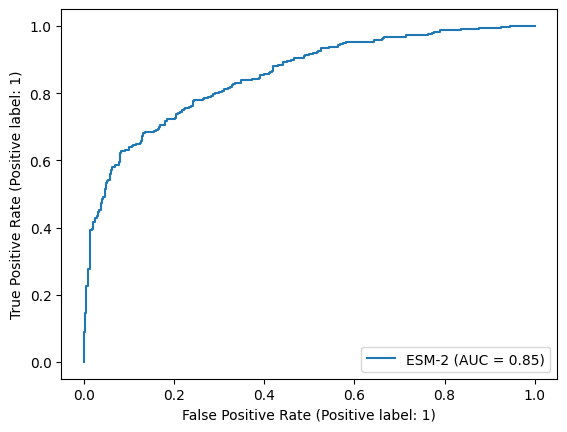

In [131]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(
    xgb, X_test_all, y_test_all, name="ESM-2", pos_label=1
)


In [132]:
eval_set = [(X_test_all, y_test_all)]
xgb = XGBClassifier(objective= 'binary:logistic', eval_metric=roc_auc_score, n_estimators=200)

xgb.fit(X_train_all, y_train_all, early_stopping_rounds=300, eval_set=eval_set, verbose=True)

preds_test = xgb.predict(X_test_all)

roc_auc_score(y_test_all, xgb.predict_proba(X_test_all)[:, 1])

[0]	validation_0-logloss:0.64301	validation_0-roc_auc_score:0.69843
[1]	validation_0-logloss:0.60266	validation_0-roc_auc_score:0.75639
[2]	validation_0-logloss:0.58450	validation_0-roc_auc_score:0.76477
[3]	validation_0-logloss:0.56449	validation_0-roc_auc_score:0.78323
[4]	validation_0-logloss:0.54899	validation_0-roc_auc_score:0.79550
[5]	validation_0-logloss:0.53931	validation_0-roc_auc_score:0.80444
[6]	validation_0-logloss:0.53148	validation_0-roc_auc_score:0.81112
[7]	validation_0-logloss:0.52441	validation_0-roc_auc_score:0.81666
[8]	validation_0-logloss:0.51724	validation_0-roc_auc_score:0.82239
[9]	validation_0-logloss:0.51918	validation_0-roc_auc_score:0.82188
[10]	validation_0-logloss:0.52264	validation_0-roc_auc_score:0.81964
[11]	validation_0-logloss:0.52397	validation_0-roc_auc_score:0.82076
[12]	validation_0-logloss:0.52350	validation_0-roc_auc_score:0.82164
[13]	validation_0-logloss:0.52396	validation_0-roc_auc_score:0.82379
[14]	validation_0-logloss:0.52086	validation

0.698427686929731

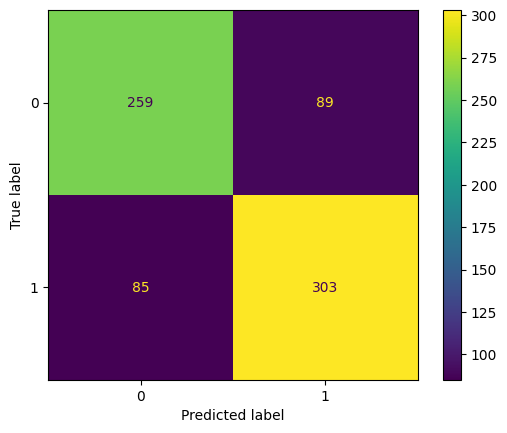

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_all, preds_test, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb.classes_)
disp.plot()
plt.show()


In [140]:
print(xgb.feature_importances_)
print()
print('Length of feature_importances_ list: ' + str(len(xgb.feature_importances_)))
print()
print('Number of predictors in X_train_all: ' + str(X_train_all.shape[1]))


[0.         0.00063592 0.00107225 ... 0.00036472 0.         0.        ]

Length of feature_importances_ list: 1280

Number of predictors in X_train_all: 1280


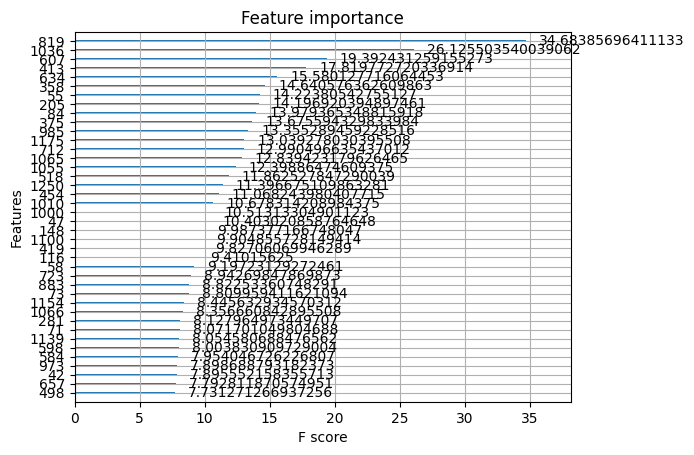

In [141]:
plot_importance(xgb, max_num_features=40, importance_type='gain')
pyplot.show()


In [142]:
feature_names = X_train_all.columns

feature_importance_df = pd.DataFrame(xgb.feature_importances_, feature_names)
feature_importance_df = feature_importance_df.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df


,Feature,Importance
0,0,0.000000
1,1,0.000636
2,2,0.001072
3,3,0.000085
4,4,0.000000
...,...,...
1275,1275,0.001956
1276,1276,0.000000
1277,1277,0.000365
1278,1278,0.000000


In [154]:
feature_importance_df_top_50 = feature_importance_df.sort_values(by='Importance', ascending=False).head(200)
feature_importance_df_top_50


,Feature,Importance
819,819,0.019693
1036,1036,0.014834
607,607,0.011011
413,413,0.010118
634,634,0.008846
...,...,...
1131,1131,0.001631
742,742,0.001617
401,401,0.001607
1043,1043,0.001598


<BarContainer object of 50 artists>

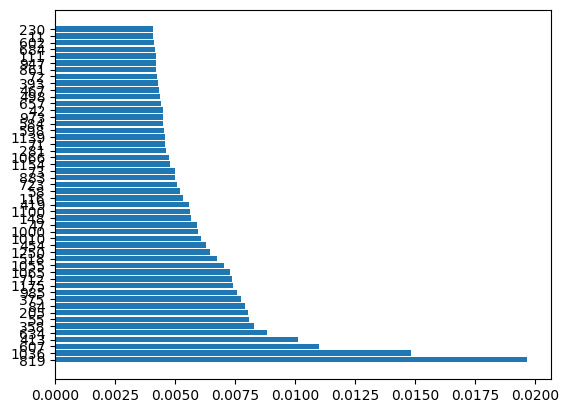

In [144]:
plt.barh(feature_importance_df_top_50.Feature, feature_importance_df_top_50.Importance)



Length of remaining predictors after XGB: 865


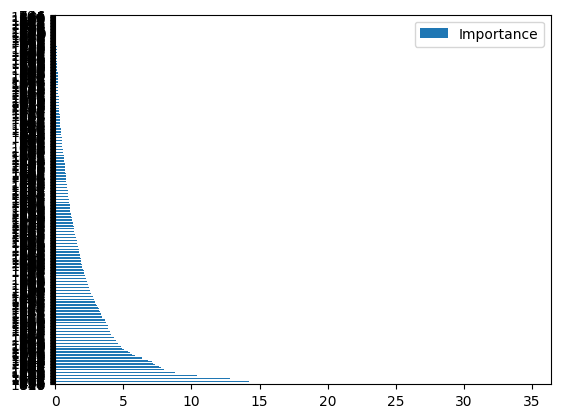

In [145]:
features_selected_from_XGBoost = xgb.get_booster().get_score(importance_type='gain')
keys = list(features_selected_from_XGBoost.keys())
values = list(features_selected_from_XGBoost.values())

features_selected_from_XGBoost = pd.DataFrame(data=values, 
                                              index=keys, 
                                              columns=["Importance"]).sort_values(by = "Importance", 
                                                                             ascending=False)
features_selected_from_XGBoost.plot(kind='barh')

print()
print('Length of remaining predictors after XGB: ' + str(len(features_selected_from_XGBoost)))


In [146]:
print(feature_importance_df[(feature_importance_df["Importance"] == 0)])
print()
print('Length of features with Importance = zero:  ' + str(feature_importance_df[(feature_importance_df["Importance"] == 0)].shape[0] ))


     Feature  Importance
0          0         0.0
4          4         0.0
6          6         0.0
7          7         0.0
8          8         0.0
...      ...         ...
1271    1271         0.0
1272    1272         0.0
1276    1276         0.0
1278    1278         0.0
1279    1279         0.0

[415 rows x 2 columns]

Length of features with Importance = zero:  415


In [147]:
top_50_of_retained_features_from_model = features_selected_from_XGBoost.sort_values(by='Importance', ascending=False).head(50)
top_50_of_retained_features_from_model


,Importance
819,34.683857
1036,26.125504
607,19.392431
413,17.819773
634,15.580128
358,14.640576
55,14.223805
205,14.196920
84,13.979365
375,13.675594


In [189]:
top_50_of_retained_features_from_model = features_selected_from_XGBoost.sort_values(by='Importance', ascending=False).head(50)

xgb = XGBClassifier(objective= 'binary:logistic')
xgb.fit(X_train_dna[top_50_of_retained_features_from_model.index], y_train_dna)

roc_auc_score(y_test_dna, xgb.predict_proba(X_test_dna[top_50_of_retained_features_from_model.index])[:, 1])

0.6534778225806452

In [39]:
fit_params={"eval_set" : [[X_test_all, y_test_all]]}

xgb_grid = XGBClassifier(objective= 'binary:logistic', early_stopping_rounds=10, eval_metric="accuracy")
parameters = {
    'max_depth': range (2, 10, 1),
    'colsample_bytree': [0.5, 0.8],     
    'gamma': [0.5, 1, 1.5],   
    'n_estimators': range(50, 250, 50),
    'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1]}


In [40]:
cv = 3

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=parameters,
    scoring = 'neg_log_loss',
    # n_jobs = -1,
    cv = TimeSeriesSplit(n_splits=cv).get_n_splits([X_train_all, y_train_all]),
    verbose=1)

xgb_grid_model = grid_search.fit(X_train_all, y_train_all, **fit_params)


Fitting 3 folds for each of 960 candidates, totalling 2880 fits


KeyboardInterrupt: 

In [ ]:
print('Best Parameter:')
print(xgb_grid_model.best_params_) 
print()
print('------------------------------------------------------------------')
print()
print(xgb_grid_model.best_estimator_)


In [ ]:
preds_train = xgb_grid_model.predict(X_train_all)
preds_test = xgb_grid_model.predict(X_test_all)

print('XGBoosting with GridSearch:\n> Accuracy on training data = {:.4f}\n> Accuracy on validation data = {:.4f}'.format(
    accuracy_score(y_true=y_train_all, y_pred=preds_train),
    accuracy_score(y_true=y_test_all, y_pred=preds_test)
))


In [ ]:
1. Сбалансированные классы
2. Бустинги (разные)
3. Бенчмарк
4. Гиперпараметры
5. Сравнить с статьями